# Analysis of Cord Color Contextual Embeddings

To analyze what our AI khipukamayuq has learned, let us first read in our pretrained model from `training.ipynb`. We'll also need to define a number of functions for computing and analyzing contextual embeddings.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import subprocess
from datasets import load_from_disk, Dataset
from transformers import BertTokenizerFast, BertForMaskedLM
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
import torch
import pandas as pd
import os
import numpy as np
import umap
import hdbscan
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sqlite3

# By default, load precomputed data and pretrained models
USE_PRECOMPUTED = True
SEED = 7
file_path = "data/"
cluster_model_path = "clustering/"
model_path = "pretrained-bert/"

# maximum sequence length
max_length = 512

# when the tokenizer is trained and configured, load it as BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# Mapping function to tokenize with truncation + padding to match max length
encode = lambda x: tokenizer(x["color"],
                             return_special_tokens_mask=True,
                             truncation=True,
                             max_length=max_length)

# Load pretrained model in eval mode
model = BertForMaskedLM.from_pretrained(os.path.join(model_path,
                                                     "checkpoint-400"),
                                        output_attentions=True,
                                        output_hidden_states=True)
model.eval()

# Define functions used for encoding cords and analysis
def concat_last_four_layers(input_ids, model):
    with torch.no_grad():
      # don't need to do gradient calcs
      out = model(input_ids=input_ids)

    # only need hidden states
    hidden_states = out.hidden_states
    # concat last four layers as per BERT paper
    cat = torch.cat(tuple(hidden_states[i] for i in range(-1, -5, -1)), dim=-1)
    return cat

def compute_cg_embedding(input_ids, model):
    cat = concat_last_four_layers(input_ids, model)
      # compute avg token embedding for cord group
      # produces (1, 3072) embedding == 4*768 layer size
    cg_embedding = torch.mean(cat, dim=1).squeeze()
    return cg_embedding

def compute_token_embedding_by_pos(input_ids, model, token_pos):
    cat = concat_last_four_layers(input_ids, model)
    token_embedding = cat.squeeze()[token_pos]
    return token_embedding

def compute_token_embedding(inputs, model, color, color_token_ids):
    # inputs = cg string (from dataset)
    # color_token_ids = dict with color:id mappings
    token_id = color_token_ids[color]
    token_index = (inputs == token_id).nonzero(as_tuple=True)[1]
    cat = concat_last_four_layers(inputs, model)
    token_embedding = cat.squeeze()[token_index]
    return token_embedding

def batch_encode_data(dataset):
    # tokenize full dataset using encode function from before
    encoded = dataset.map(encode, batched=True)
    # convert from lists to torch tensors
    encoded.set_format("torch", columns=['input_ids'])
    return encoded

def map_cg_embedding_computation(encoded, model, file_path=False):
    dataset_w_embeddings = encoded.map(lambda x:
    {'cg_embeddings': compute_cg_embedding(x['input_ids'].unsqueeze(0), model)})
    dataset_w_embeddings.set_format("torch", columns=['cg_embeddings'])

    if file_path:
        dataset_w_embeddings.save_to_disk(f"{file_path}/cg_embeddings")

    return dataset_w_embeddings

def map_embedding_computation(encoded_dataset, model, color, color_token_ids,
                              file_path=False, num_proc=None):
    dataset_w_embeddings = \
        encoded_dataset.filter(lambda x:
                               color_token_ids[color] in x['input_ids']) \
                       .map(lambda x: {'embeddings': compute_token_embedding(
                                      x['input_ids'].unsqueeze(0),
                                      model,
                                      color,
                                      color_token_ids)},
                            num_proc=num_proc)
    dataset_w_embeddings.set_format("torch", columns=['embeddings'])

    if file_path:
        if color == ':':
            color_name = 'mot'
        elif color == '-':
            color_name = 'bp'
        elif color == '/':
            color_name = 'seg'
        else:
            color_name = color
        dataset_w_embeddings.save_to_disk(
            f"{file_path}/token_embeddings_{color_name}"
            )

    return dataset_w_embeddings

def unique_cos_sims(cos_sim_mat):
    mask = np.ones_like(cos_sim_mat, dtype=bool)
    mask[np.triu_indices_from(mask)] = False
    return cos_sim_mat[mask]

def compute_cos_sims_for_color(embeddings, by='overall'):
    df = embeddings.to_pandas()
    if by == 'overall' and len(df.embeddings) > 0:
        x = np.concatenate(df.embeddings)
        x = cosine_similarity(np.vstack(x))
        x = unique_cos_sims(x)
    elif by == 'khipu' and len(df.embeddings) > 0:
        x = df.groupby('okr_num').embeddings \
              .apply(lambda x: np.concatenate(list(x))) \
              .apply(lambda x: cosine_similarity(np.vstack(x))) \
              .apply(unique_cos_sims)
    elif by == 'provenance' and len(df.embeddings) > 0:
        df = pd.merge(left=df, right=df_geo, on='okr_num')
        x = df.groupby('provenance').embeddings \
              .apply(lambda x: np.concatenate(list(x))) \
              .apply(lambda x: cosine_similarity(np.vstack(x))) \
              .apply(unique_cos_sims)
    else:
        x = np.array([], dtype=np.float32)

    return x

def locate_divergent_cgs(embeddings, threshold=0.5):
    df = embeddings.to_pandas()
    df.loc[:, 'cos_sim'] = pd.Series(
        list(
            cosine_similarity(
                np.vstack(
                    df.embeddings.apply(lambda x: np.mean(list(x), axis=0))
                )
            )
        )
    )

    # at level of a particular cluster, is the use of a particular color 
    # divergent (as per threshold) from its use in other clusters?
    most_divergent_idx = np.concatenate(
       df.cos_sim.apply(lambda l: [i for i, c in enumerate(l) if c < threshold])
    )

    # if, so compute the overall count and % of clusters it diverges from
    unique_divergent_idx, counts = np.unique(most_divergent_idx,
                                             return_counts=True)
    df.loc[unique_divergent_idx, 'divergence_count'] = counts
    df.loc[unique_divergent_idx, 'divergence_pct'] = counts / (df.shape[0] - 1)

    return df

def extract_cluster_sizes(df, by='overall', clusters=None):
    cluster_sizes = None
    if by == 'overall':
        cluster_sizes = df.groupby(['label']) \
                          .doc \
                          .count() \
                          .reset_index() \
                          .rename({'doc': 'size'}, axis='columns') \
                          .sort_values('size', ascending=False)
    elif by == 'khipu':
        cluster_sizes = df.groupby(['label', 'okr_num']) \
                          .doc \
                          .count() \
                          .reset_index() \
                          .rename({'doc': 'size'}, axis='columns') \
                          .sort_values("size", ascending=False)
    elif by == 'provenance':
        df = pd.merge(left=df, right=df_geo, on='okr_num')
        cluster_sizes = df.groupby(['label', 'provenance']) \
                          .doc \
                          .count() \
                          .reset_index() \
                          .rename({'doc': 'size'}, axis='columns') \
                          .sort_values("size", ascending=False)

    if clusters:
        return cluster_sizes[cluster_sizes.label.isin(clusters)]

    return cluster_sizes

## Preprocess Data

Then, we can download the OKR (v2.0.0) if we haven't already done so and select all of the cord color sequences in the database. Finally, we preprocess the data so that it is in the form our model expects for computing contextual embeddings.

In [2]:
# If haven't already done so...
# download OKR v2.0.0 and select KCCS (Brezine) + Ascher color codes
# ordered by khipu and cord position
try:
    subprocess.Popen(['git', 
                      'clone', 
                      'https://github.com/khipulab/open-khipu-repository.git',
                      '-b', 'v2.0.0', '--single-branch',
                      '--quiet'])
except Exception as e:
    print(e)

conn = sqlite3.connect('open-khipu-repository/khipu.db')

query = \
'''
SELECT
    okr_num,
    cord.khipu_id,
    cluster_id,
    cord_id,
    cord_ordinal,
    cluster_ordinal,
    (SELECT color_concat
      FROM
          (SELECT
              GROUP_CONCAT(REPLACE(TRIM(
                REPLACE(TRIM(color.color_cd_1, '*:- '), ' ', '')
                || case when color.operator_1 <> ''
                then ' ' || color.operator_1 else '' END
                || case when color.color_cd_2 <> ''
                then '' || REPLACE(TRIM(color.color_cd_2, '*:- '), ' ', '') else '' END
                || case when color.operator_2 <> ''
                then ' ' || color.operator_2 else '' END
                || case when color.color_cd_3 <> ''
                then '' || REPLACE(TRIM(color.color_cd_3, '*:- '), ' ', '') else '' END
                || case when color.operator_3 <> ''
                then ' ' || color.operator_3 else '' END
                || case when color.color_cd_4 <> ''
                then '' || REPLACE(TRIM(color.color_cd_4, '*:- '), ' ', '') else '' END
                || case when color.operator_4 <> ''
                then ' ' || color.operator_4 else '' END
                || case when color.color_cd_5 <> ''
                then '' || REPLACE(TRIM(color.color_cd_5, '*:- '), ' ', '') else '' END
                || case when color.operator_5 <> ''
                then ' ' || color.operator_5 else '' END,
                '*:- '), ' ', ''), '/') AS color_concat,
            cord_id
          FROM
              ascher_cord_color AS color
          GROUP BY
              cord_id
          ORDER BY
              color_range

          )
      WHERE
          cord_id = cord.cord_id
    ) as acs,
    /* Get clean colors and concatenate colors of segmented cords */
    (SELECT color_concat
      FROM
          (SELECT
              GROUP_CONCAT(REPLACE(TRIM(
              c1.color || c1.intensity
                || case when color.operator_1 <> ''
                then '' || color.operator_1 else '' END
                || case when color.color_cd_2 <> ''
                then '' || c2.color || c2.intensity else '' END
                || case when color.operator_2 <> ''
                then '' || color.operator_2 else '' END
                || case when color.color_cd_3 <> ''
                then '' || c3.color || c3.intensity else '' END
                || case when color.operator_3 <> ''
                then '' || color.operator_3 else '' END
                || case when color.color_cd_4 <> ''
                then '' || c4.color || c4.intensity else '' END
                || case when color.operator_4 <> ''
                then '' || color.operator_4 else '' END
                || case when color.color_cd_5 <> ''
                then '' || c5.color || c5.intensity else '' END
                || case when color.operator_5 <> ''
                then '' || color.operator_5 else '' END,
                '*:- '), ' ', ''), '/') AS color_concat,
            cord_id
          FROM
              ascher_cord_color AS color
          /*
          Find corresponding colors/intensities for Ascher color codes
          using Brezine lookup table in db.
          Note that some records also have extraneous chars to clean
          */
          LEFT JOIN ascher_color_dc AS c1
              ON REPLACE(TRIM(color.color_cd_1, '*:- '), ' ', '') = \
                REPLACE(TRIM(c1.as_color_cd, '*:- '), ' ', '')
          LEFT JOIN ascher_color_dc AS c2
              ON REPLACE(TRIM(color.color_cd_2, '*:- '), ' ', '') = \
                REPLACE(TRIM(c2.as_color_cd, '*:- '), ' ', '')
          LEFT JOIN ascher_color_dc AS c3
              ON REPLACE(TRIM(color.color_cd_3, '*:- '), ' ', '') = \
                REPLACE(TRIM(c3.as_color_cd, '*:- '), ' ', '')
          LEFT JOIN ascher_color_dc AS c4
              ON REPLACE(TRIM(color.color_cd_4, '*:- '), ' ', '') = \
                REPLACE(TRIM(c4.as_color_cd, '*:- '), ' ', '')
          LEFT JOIN ascher_color_dc AS c5
              ON REPLACE(TRIM(color.color_cd_5, '*:- '), ' ', '') = \
                REPLACE(TRIM(c5.as_color_cd, '*:- '), ' ', '')
          GROUP BY
              cord_id
          ORDER BY
              color_range

          )
      WHERE
          cord_id = cord.cord_id
      ) AS color
FROM
    cord
JOIN
    khipu_main ON cord.khipu_id = khipu_main.khipu_id
WHERE
    /*
    First order cords -- top cords indicated with negative in deprecated
    coding scheme, pendant cords with positive
    */
    (cord_level = 1 OR cord_level = -(1))
ORDER BY
    okr_num,
    cord_ordinal
'''

# run query and prepare data for encoding
khipu_df = pd.read_sql_query(query, conn)
khipus_wo_cg = (khipu_df.CLUSTER_ID == 0) & (khipu_df.CLUSTER_ORDINAL == 0)
khipu_df.loc[khipus_wo_cg,
             'CLUSTER_ID'] = khipu_df.loc[khipus_wo_cg]['OKR_NUM']

# drop (7) cords that are missing cluster ID, but have non-zero cluster ordinal
khipu_df = khipu_df[khipu_df.CLUSTER_ID != 0]
khipu_df.loc[:, 'CLUSTER_ID'] = khipu_df.loc[:, 'CLUSTER_ID'].astype(str)

# Drop khipus that have no recorded colors on them
# (but keep cords without recorded colors if other portions of the khipu
# are recorded)
khipu_ids_to_check = khipu_df.loc[khipu_df.color.isna()] \
                             .groupby('KHIPU_ID') \
                             .count() \
                             .sort_values('color', ascending=False) \
                             .color \
                             .index

all_cord_colors_missing = []
for id in khipu_ids_to_check:
    if len(khipu_df[(khipu_df.KHIPU_ID == id) & (khipu_df.color.isna())]) \
        == (len(khipu_df[(khipu_df.KHIPU_ID == id)])):
        all_cord_colors_missing.append(id)

khipu_df = khipu_df.loc[~khipu_df.KHIPU_ID.isin(all_cord_colors_missing)] \
                   .rename(columns={'OKR_NUM': 'okr_num',
                                    'CLUSTER_ID': 'cluster_id'})
khipu_cg_map = khipu_df[['okr_num', 'cluster_id']].drop_duplicates()

# Fill NA values as [UNK] for encoding
khipu_df.loc[khipu_df.color.isna(), ['acs', 'color']] = '[UNK]'

# Load clean provenance data for geographic analyses
df_geo = pd.read_csv(file_path + '/geo_clean_okr_v2.csv', index_col=0)

# identify corresponding Ascher codes for each KCCS code for subcluster analysis
acs_lst_by_cluster = khipu_df.loc[:, ['cluster_id', 'acs']]
acs_lst_by_cluster.loc[:, 'acs'] = acs_lst_by_cluster.acs.str.split(r'([^a-zA-Z0|\[UNK\]])')
subset_w_no_space = acs_lst_by_cluster[acs_lst_by_cluster.acs.apply(
                                            lambda l: sum(len(i) > 2 
                                            for i in l 
                                            if i != '[UNK]')) > 0] \
    .acs.apply(lambda l: [j for i in l 
                            for j in 
                            re.findall(r'(W|LB|AB|MB|GG|BD|BG|KB|SR|MG|GL|YB|B|G|[^A-Za-z0])', i)])
acs_lst_by_cluster.loc[subset_w_no_space.index, 'acs'] = subset_w_no_space
acs_lst_by_cluster = acs_lst_by_cluster.groupby('cluster_id') \
                                       .acs.apply(list) \
                                       .apply(lambda l: [j for i in l for j in i])

# Select cord groups
cg_df = khipu_df.loc[:, ['cluster_id', 'color']] \
                .groupby('cluster_id') \
                .color.apply(' '.join)

cg_df = pd.merge(left=cg_df,
                 right=khipu_cg_map,
                 on='cluster_id')

# Tokenize data by cord group and prepare to compute embeddings
dataset = Dataset.from_pandas(cg_df.reset_index(drop=True))
encoded = batch_encode_data(dataset)

# Identify valid KCCS color/combo ids learned by tokenizer
color_token_ids = {k.capitalize(): v for k, v in tokenizer.get_vocab().items()
                        if len(k)==2 or k in [':', '-', '/']}

Map:   0%|          | 0/6592 [00:00<?, ? examples/s]

## Compute Contextual Embeddings for each Cord Color

We can then compute contextual embeddings for each token in a cord group (including color combination operators for a single cord like `:`, `-`, `/`, although these are not analyzed in the particular study). Additionally, we must compute cosine similarities between each pair of cords within a color overall, within a khipu, and within an archive. We'll use these metrics later on to interpret the degree to which a color has multiple different senses.

In [3]:
embeddings = {}
cos_sims = {}

if USE_PRECOMPUTED:
    # load precomputed embeddings from disk
    for k in color_token_ids.keys():
        # color combo files are labeled differently, so provide conversion
        if k == ':':
            color = 'mot'
        elif k == '-':
            color = 'bp'
        elif k == '/':
            color = 'seg'
        else:
            color = k
        try:
            # load embeddings into embeddings dictionary
            embeddings[k] = load_from_disk(f"{file_path}/token_embeddings_{color}")
            cos_sims[k] = {
                'overall': compute_cos_sims_for_color(embeddings[k]),
                'khipu': compute_cos_sims_for_color(embeddings[k],
                                                    by='khipu'),
                'provenance': compute_cos_sims_for_color(embeddings[k],
                                                        by='provenance')
            }
        except Exception as e:
            print(k, repr(e))
else:
    # (re)compute all embeddings for each token `k`
    for k in color_token_ids.keys():
        try:
            embeddings[k] = map_embedding_computation(encoded,
                                                      model,
                                                      k,
                                                      color_token_ids,
                                                      file_path)
            cos_sims[k] = {
                'overall': compute_cos_sims_for_color(embeddings[k]),
                'khipu': compute_cos_sims_for_color(embeddings[k],
                                                    by='khipu'),
                'provenance': compute_cos_sims_for_color(embeddings[k],
                                                        by='provenance')
            }
        except Exception as e:
            print(k, " ", repr(e))

## Identifying Clusters of Meaning

As a first step, let's assess whether different colors are actually used in different ways from one another. We can do this by reducing the dimensionality of our contextual embeddings and assessing whether colors fall in unique clusters in the embedding space.

In [4]:
if USE_PRECOMPUTED:
    umap_2comp_model = joblib.load(cluster_model_path + 'umap_2comp.lz4')
    umap_100comp_model = joblib.load(cluster_model_path + 'umap_100comp.lz4')

    cluster = joblib.load(cluster_model_path + 'hdbscan_cluster.model')
    small_cluster = joblib.load(cluster_model_path + 'hdbscan_small_cluster.model')

    avg_embeds_by_color = pd.read_pickle('clustering/avg_embeds_by_color.pkl')
    result = pd.read_pickle('clustering/clustering_result.pkl')
else:
    # Convert data to numpy arrays for dimension reduction + clustering
    color_embeds = pd.DataFrame([(k, np.concatenate(e.to_pandas().embeddings))
                              for k, e in embeddings.items() 
                              if k not in {'/', ':', '-'}], columns=['color', 'embed']).explode('embed') \
                                                                                       .reset_index()
    embeds_np = np.vstack(color_embeds.embed)

    # At low dimensionality, UMAP requires random jitter in order for spectral init to work for this data
    np.random.seed(SEED)
    data_w_noise = embeds_np + np.random.normal(0, 0.01, embeds_np.shape)

    rowwise_cos_sim = lambda x, y: np.einsum('ij,ij->i', x, y) / (np.linalg.norm(x, axis=1) * np.linalg.norm(y, axis=1))
    rowwise_cos_sim_array = rowwise_cos_sim(data_w_noise, embeds_np)
    # note trivial cosine distance between jittered results and original
    print('Added random jitter to embeddings. Minimum cosine similarity with original data: ' ,
        rowwise_cos_sim_array.min()
    )

    # reduce dimensionality from 3072 to 100; diminishing returns with HDBSCAN above this point
    # note that stochasticity may produce slightly different positions each time
    # (use precomputed embeddings and components for exact replication)
    umap_100comp_model = umap.UMAP(n_neighbors=15,
                                n_components=100,
                                min_dist=0.0,
                                metric='cosine',
                                random_state=SEED) \
                            .fit(data_w_noise)

    # Identify big, conservative clusters with HDBSCAN first to avoid overfitting to small communities of cords
    cluster = hdbscan.HDBSCAN(min_cluster_size=250,
                            prediction_data=True) \
                .fit(umap_100comp_model.embedding_)

    # Then, identify smaller clusters in same 100d data (set to 10x smaller min_cluster_size)
    small_cluster = hdbscan.HDBSCAN(min_cluster_size=25,
                                prediction_data=True) \
                    .fit(umap_100comp_model.embedding_)

    # Prepare data for plotting in two dimensions now that clusters have been identified
    umap_2comp_model = umap.UMAP(n_neighbors=15,
                            n_components=2,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=SEED) \
                .fit(data_w_noise)

    # Compute average embeddings and their cluster membership
    avg_embeds_by_color = pd.DataFrame([(k, 
                                        np.vstack(np.concatenate(e.to_pandas().embeddings)).mean(axis=0),
                                        len(np.vstack(np.concatenate(e.to_pandas().embeddings)))
                                        )
                                        for k, e in embeddings.items() 
                                        if k not in {'/', ':', '-'}],
                                        columns=['color', 'avg_embedding', 'total_count'])

    avg_embeds_np = avg_embeds_by_color.avg_embedding.values.tolist()

    avg_embeds_umap_100comp = umap_100comp_model.transform(avg_embeds_np)
    avg_embeds_clusters = hdbscan.approximate_predict(cluster, avg_embeds_umap_100comp)
    avg_embeds_clusters_sc = hdbscan.approximate_predict(small_cluster, avg_embeds_umap_100comp)
    avg_embeds_umap_2comp = umap_2comp_model.transform(avg_embeds_np)

    # Add data to dataframes and save dataframes
    avg_embeds_by_color.loc[:, ['x', 'y']] = avg_embeds_umap_2comp
    avg_embeds_by_color.loc[:, 'labels'] = avg_embeds_clusters[0]
    avg_embeds_by_color.loc[:, 'labels_sc'] = avg_embeds_clusters_sc[0]

    result = pd.DataFrame(umap_2comp_model.embedding_, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    result['labels_sc'] = small_cluster.labels_
    result = result.merge(color_embeds.loc[:, ['color', 'index']], left_index=True, right_index=True)

    # Save models to avoid recomputing in the future
    models = [umap_2comp_model, cluster, small_cluster, umap_100comp_model]
    filenames = ['umap_2comp.lz4', 'hdbscan_cluster.model', 'hdbscan_small_cluster.model', 'umap_100comp.lz4']
    for m, f in zip(models, filenames):
        if 'lz4' in f:
            joblib.dump(m, cluster_model_path + f, compress='lz4')
        else:
            joblib.dump(m, cluster_model_path + f)
    
    # save precomputed embeddings, 2D coordinates, and cluster labels as well
    avg_embeds_by_color.to_pickle(cluster_model_path + 'avg_embeds_by_color.pkl')
    result.to_pickle(cluster_model_path + 'clustering_result.pkl')

Plotting the resulting clusters in two dimensions, it looks like the most commonly used colors do appear in distinct semantic domains in the embedding space:

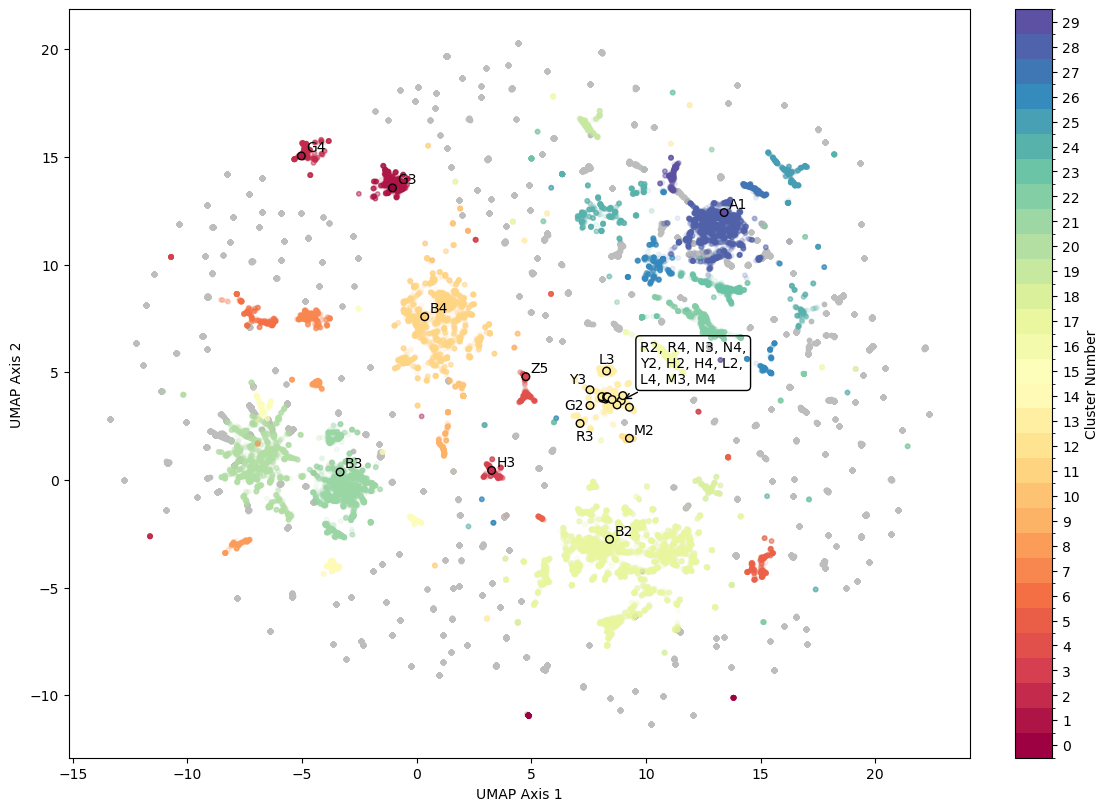

In [5]:
cmap = mpl.cm.Spectral
bounds = np.arange(result.labels.nunique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(11, 8), layout='constrained')

outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
avg_pts_by_color = avg_embeds_by_color.loc[avg_embeds_by_color.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10) # grey
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap=cmap, alpha=0.1)
plt.scatter(avg_pts_by_color.x, avg_pts_by_color.y,
            c=avg_pts_by_color.labels, s=30, linewidths=1,
            edgecolors='k', cmap=cmap)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             ax=ax, orientation='vertical', label='Cluster Number')
cb.set_ticks(bounds[:-1] + 0.5)
cb.set_ticklabels(bounds[:-1])
plt.xlabel('UMAP Axis 1')
plt.ylabel('UMAP Axis 2')
# Some labels are too bunched together; spread them out to enhance readability
for i in avg_pts_by_color.loc[:, ['color', 'x', 'y', 'labels']].itertuples():
    if (i[4] != 13):
        ax.annotate(i[1], (i[2] + 0.2, i[3] + 0.2))
    else:
        if i[1] == 'R3':
            ax.annotate(i[1], (i[2] - .2, i[3] - 0.8))
        elif i[1] == 'G2':
            ax.annotate(i[1], (i[2] - 1.1, i[3] - .2))
        elif i[1] == 'Y3':
            ax.annotate(i[1], (i[2] - .9, i[3] + 0.28))
        elif i[1] == 'L3':
            ax.annotate(i[1], (i[2] - .35, i[3] + 0.35))
        elif i[1] == 'M3':
            remaining_colors = 'R2, R4, N3, N4,\nY2, H2, H4, L2,\nL4, M3, M4'
            ax.annotate(remaining_colors, 
                        xy=(i[2] + 0.2, i[3] + 0.2),
                        xytext=(i[2] + 1, i[3] + 1),
                        bbox=dict(boxstyle='round', fc='None'),
                        arrowprops=dict(arrowstyle='->')
            )

We can also see that the average embeddings for many colors are members of unique clusters (with the exception of cluster 13 -- which seems to contain cord colors that appear more rarely):

In [6]:
print(avg_embeds_by_color.groupby('labels').color.apply(lambda x: ' '.join(x)))
print(avg_embeds_by_color.groupby('labels').total_count.sum())

labels
1                                               G3
2                                               G4
3                                               H3
4                                               Z5
11                                              B4
12                                              M2
13    L3 L2 N4 Y3 R4 H2 N3 G2 R3 M3 L4 M4 R2 Y2 H4
17                                              B2
21                                              B3
28                                              A1
Name: color, dtype: object
labels
1      1150
2       544
3       538
4       750
11     4989
12      258
13     1776
17    10857
21    11529
28    16245
Name: total_count, dtype: int64


Note as well that these clusters seem to account for the majority of the variation in how cord colors are used:

In [7]:
print(f'Overall cords in a cluster {100 * (result.labels != -1).sum() / len(result)}%')
for i in avg_pts_by_color.loc[:, ['color', 'labels']].itertuples():
    same_color = result.color == i[1]
    in_a_cluster = result.labels != -1
    print(
        f'{i[1]} in a cluster: {100 * (same_color & in_a_cluster).sum() / same_color.sum()}%\n',
        f'Average embedding is in cluster {i[2]}\n',
        f'{result[same_color & in_a_cluster].groupby("labels").labels.count()}'       
    )

Overall cords in a cluster 79.04227321325767%
G4 in a cluster: 92.09558823529412%
 Average embedding is in cluster 2
 labels
2    501
Name: labels, dtype: int64
A1 in a cluster: 65.59556786703601%
 Average embedding is in cluster 28
 labels
0       40
16     694
19     425
22    1070
23     929
24    1332
25     596
26    1166
27     399
28    3614
29     391
Name: labels, dtype: int64
B4 in a cluster: 96.29184205251553%
 Average embedding is in cluster 11
 labels
4        5
9      336
10     270
11    4193
Name: labels, dtype: int64
G3 in a cluster: 99.21739130434783%
 Average embedding is in cluster 1
 labels
1    1141
Name: labels, dtype: int64
L3 in a cluster: 100.0%
 Average embedding is in cluster 13
 labels
13    343
Name: labels, dtype: int64
L2 in a cluster: 96.23655913978494%
 Average embedding is in cluster 13
 labels
13    179
Name: labels, dtype: int64
N4 in a cluster: 100.0%
 Average embedding is in cluster 13
 labels
13    43
Name: labels, dtype: int64
Y3 in a cluster: 9

Given the large number of clusters associated with B2, B3, and B4, we might ask whether these are simply attributable to the use of the aggregated KCCS color codes (as opposed to the Ascher color codes they aggregate). Do the different clusters just map onto different uses specific to the Ascher color codes?

This is particularly pertinent at Inkawasi (see Clindaniel 2019), where color combination cords sometimes feature multiple browns in the Ascher system that aggregate under the same KCCS code (i.e. B2:B2 cord where a B2 color is mottled with another B2 color). Let's assess whether there are any differences in clustering by Ascher codes overall, as well as at Inkawasi in particular.

First, we can start with B2:

In [8]:
acs_embeddings = {}
color_set_to_check = {'YB', 'BY', 'AB', 'RL', 'GB'}
embeddings_for_color = embeddings['B2'].to_pandas()
embeddings_for_color = embeddings_for_color \
    .join(acs_lst_by_cluster.apply(lambda l: [i for i in l if i in color_set_to_check]),
          on='cluster_id')
embeddings_for_color = embeddings_for_color[
    embeddings_for_color.apply(lambda x: len(x.embeddings) == len(x.acs), axis=1)
    ]
embeddings_for_color_geo = pd.merge(left=embeddings_for_color, right=df_geo, on='okr_num')

acs_embeddings['B2'] = embeddings_for_color.explode(['embeddings', 'acs'])
acs_embeddings['B2_geo'] = embeddings_for_color_geo.explode(['embeddings', 'acs'])

There don't seem to be clearly discernable differences between how the different Ascher codes are behaving at overall, or at Inkawasi:

In [9]:
# all centered in cluster 17 with roughly equivalent distribution across clusters
embeds = acs_embeddings['B2'].groupby('acs').embeddings.apply(np.vstack)
for c, e in embeds.items():
    print(f'{c}')

    embeds_umap_100comp = umap_100comp_model.transform(e)
    embeds_clusters = hdbscan.approximate_predict(cluster, embeds_umap_100comp)

    s = pd.Series(embeds_clusters[0]).value_counts().sort_index()
    print(pd.DataFrame({'count': s, 'pct': s / s.sum()}, index=s.index))

AB
     count       pct
-1    1244  0.150296
 0     165  0.019935
 5     474  0.057267
 17   5969  0.721155
 18    425  0.051347
BY
     count       pct
-1      24  0.100000
 0       3  0.012500
 5      20  0.083333
 17    179  0.745833
 18     14  0.058333
GB
     count       pct
-1       7  0.129630
 5       7  0.129630
 17     33  0.611111
 18      7  0.129630
RL
     count       pct
-1       7  0.017157
 0       3  0.007353
 5      29  0.071078
 17    369  0.904412
YB
     count       pct
-1     424  0.227346
 0      47  0.025201
 5     123  0.065952
 17   1226  0.657373
 18     45  0.024129


In [10]:
embeds = acs_embeddings['B2_geo'].groupby(['acs', 'provenance']).embeddings.apply(np.vstack)
for c, p in embeds.index:
    if c in {'AB', 'YB', 'RL'} and p == 'Incahuasi':
        print(c, p)
        embeds_umap_100comp = umap_100comp_model.transform(embeds[c][p])
        embeds_clusters = hdbscan.approximate_predict(cluster, embeds_umap_100comp)

        s = pd.Series(embeds_clusters[0]).value_counts().sort_index()
        print(pd.DataFrame({'count': s, 'pct': s / s.sum()}, index=s.index))

AB Incahuasi
     count       pct
-1     274  0.215578
 0      17  0.013375
 5     124  0.097561
 17    842  0.662470
 18     14  0.011015
RL Incahuasi
    count  pct
17     21  1.0
YB Incahuasi
     count       pct
-1      19  0.106145
 0       3  0.016760
 5      12  0.067039
 17    130  0.726257
 18     15  0.083799


How about for B3?

In [11]:
color_set_to_check = {'FR', '0B', 'MB', 'LB', 'BS', 'B', 'RB', 'NB', 'EB'}
embeddings_for_color = embeddings['B3'].to_pandas()
embeddings_for_color = embeddings_for_color \
    .join(acs_lst_by_cluster.apply(lambda l: [i for i in l if i in color_set_to_check]),
          on='cluster_id')
embeddings_for_color = embeddings_for_color[
    embeddings_for_color.apply(lambda x: len(x.embeddings) == len(x.acs), axis=1)
    ]
embeddings_for_color_geo = pd.merge(left=embeddings_for_color, right=df_geo, on='okr_num')

acs_embeddings['B3'] = embeddings_for_color.explode(['embeddings', 'acs'])
acs_embeddings['B3_geo'] = embeddings_for_color_geo.explode(['embeddings', 'acs'])

Again, there don't seem to be clearly discernable differences between how the different Ascher codes are behaving at overall, or at Inkawasi:

In [12]:
# All centered in clusters 20 and 21 with roughly equivalent distribution across clusters
# inconsistencies only present for codes with extremely small sample sizes
embeds = acs_embeddings['B3'].groupby('acs').embeddings.apply(np.vstack)
for c, e in embeds.items():
    print(f'\n{c}\n')

    embeds_umap_100comp = umap_100comp_model.transform(e)
    embeds_clusters = hdbscan.approximate_predict(cluster, embeds_umap_100comp)

    s = pd.Series(embeds_clusters[0]).value_counts().sort_index()
    print(pd.DataFrame({'count': s, 'pct': s / s.sum()}, index=s.index))


0B

     count       pct
-1       4  0.093023
 7       1  0.023256
 8       7  0.162791
 20     14  0.325581
 21     17  0.395349

B

     count       pct
-1     792  0.359184
 2      15  0.006803
 3       5  0.002268
 6     141  0.063946
 7      85  0.038549
 8     113  0.051247
 14     67  0.030385
 15     74  0.033560
 20    524  0.237642
 21    389  0.176417

BS

     count       pct
-1      65  0.241636
 3       1  0.003717
 6      21  0.078067
 7      26  0.096654
 8       9  0.033457
 14      3  0.011152
 15      2  0.007435
 20     53  0.197026
 21     89  0.330855

EB

     count   pct
-1       9  0.36
 6       1  0.04
 8       5  0.20
 20      4  0.16
 21      6  0.24

FR

     count       pct
-1      10  0.151515
 6       1  0.015152
 7       4  0.060606
 14     15  0.227273
 20     21  0.318182
 21     15  0.227273

LB

     count       pct
-1     498  0.438380
 3       4  0.003521
 6      36  0.031690
 7      62  0.054577
 8      25  0.022007
 14     19  0.016725
 15     

In [13]:
embeds = acs_embeddings['B3_geo'].groupby(['acs', 'provenance']).embeddings.apply(np.vstack)
for c, p in embeds.index:
    if c in {'MB', '0B'} and p == 'Incahuasi':
        print(c, p)
        embeds_umap_100comp = umap_100comp_model.transform(embeds[c][p])
        embeds_clusters = hdbscan.approximate_predict(cluster, embeds_umap_100comp)

        s = pd.Series(embeds_clusters[0]).value_counts().sort_index()
        print(pd.DataFrame({'count': s, 'pct': s / s.sum()}, index=s.index))

0B Incahuasi
     count       pct
-1       4  0.235294
 8       4  0.235294
 20      6  0.352941
 21      3  0.176471
MB Incahuasi
     count       pct
-1      65  0.137131
 2       1  0.002110
 6      20  0.042194
 7       8  0.016878
 8      33  0.069620
 14     19  0.040084
 15     16  0.033755
 20    216  0.455696
 21     96  0.202532


Finally, let's look at B4:

In [14]:
color_set_to_check = {'CB', 'BD', 'HB', 'BB', 'KB', 'RD', 'PR', 'DB'}
embeddings_for_color = embeddings['B4'].to_pandas()
embeddings_for_color = embeddings_for_color \
    .join(acs_lst_by_cluster.apply(lambda l: [i for i in l if i in color_set_to_check]),
          on='cluster_id')
embeddings_for_color = embeddings_for_color[
    embeddings_for_color.apply(lambda x: len(x.embeddings) == len(x.acs), axis=1)
    ]
embeddings_for_color_geo = pd.merge(left=embeddings_for_color, right=df_geo, on='okr_num')

acs_embeddings['B4'] = embeddings_for_color.explode(['embeddings', 'acs'])
acs_embeddings['B4_geo'] = embeddings_for_color_geo.explode(['embeddings', 'acs'])

Again, there don't seem to be clear differences between codes:

In [15]:
# All centered in cluster 11; slightly different distributions, but very small sample sizes
embeds = acs_embeddings['B4'].groupby('acs').embeddings.apply(np.vstack)
for c, e in embeds.items():
    print(f'\n{c}\n')

    embeds_umap_100comp = umap_100comp_model.transform(e)
    embeds_clusters = hdbscan.approximate_predict(cluster, embeds_umap_100comp)

    s = pd.Series(embeds_clusters[0]).value_counts().sort_index()
    print(pd.DataFrame({'count': s, 'pct': s / s.sum()}, index=s.index))


BB

     count       pct
-1       4  0.009828
 9      18  0.044226
 10      6  0.014742
 11    379  0.931204

BD

    count  pct
11    107  1.0

CB

     count       pct
-1      26  0.061611
 9      27  0.063981
 10     17  0.040284
 11    352  0.834123

DB

     count       pct
-1      66  0.072607
 9      81  0.089109
 10    155  0.170517
 11    607  0.667767

HB

     count       pct
-1      32  0.047128
 4       4  0.005891
 9      55  0.081001
 10     54  0.079529
 11    534  0.786451

KB

     count       pct
-1      45  0.019464
 4       1  0.000433
 9     144  0.062284
 10     18  0.007785
 11   2104  0.910035

PR

     count       pct
-1      12  0.109091
 9       5  0.045455
 10     15  0.136364
 11     78  0.709091

RD

     count       pct
-1       2  0.057143
 9       5  0.142857
 10      7  0.200000
 11     21  0.600000


Using a conservative clustering method, our most common colors -- A1, B2, B3, B4 -- are disambiguable (as are Z5, G3, G4, M2, and H3). To better disambiguate the colors in cluster 13, we can permit HDBSCAN to identify smaller minimum cluster sizes (25 instead of 250). Note that all of the colors in cluster 13 appear much less frequently, so cannot form their own independent clusters using the original, coarse-grained clustering method. Let's take a look at the smaller "sub-clusters" that HDBSCAN identifies within cluster 13:

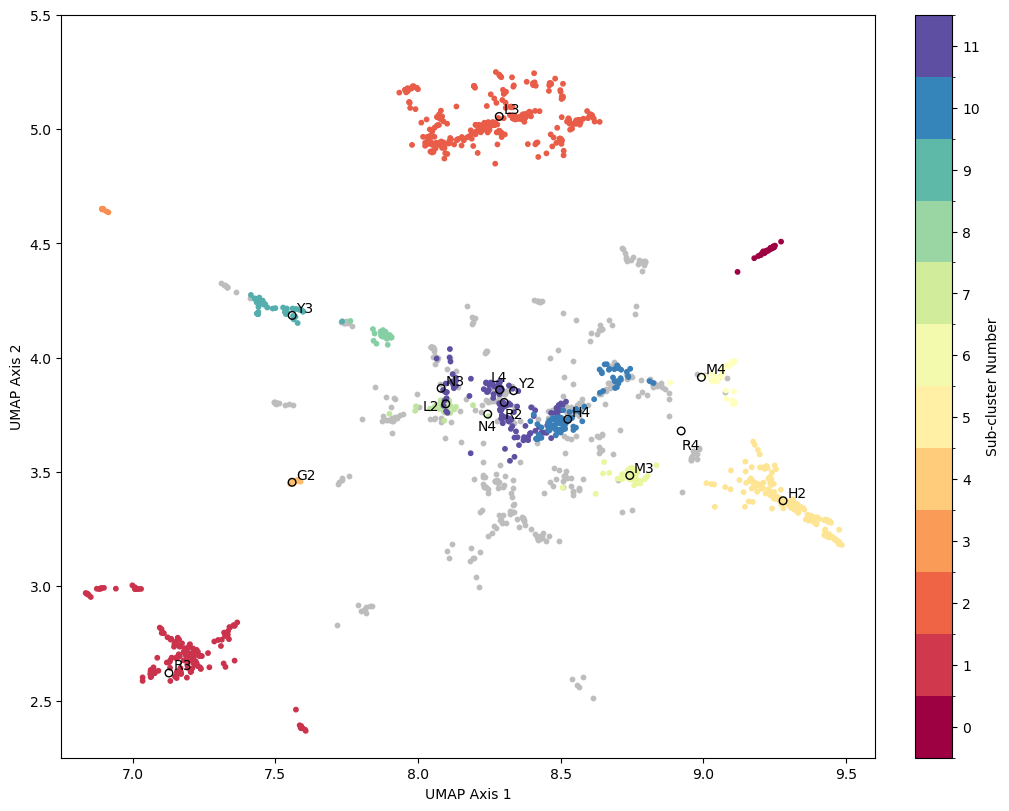

In [16]:
cmap = mpl.cm.Spectral
bounds = np.arange(result[(result.labels == 13) & (result.labels_sc != -1)].labels_sc.nunique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 8), layout='constrained')

outliers_sc = result.loc[(result.labels == 13) & (result.labels_sc == -1), :]
clustered_sc = result.loc[(result.labels == 13) & (result.labels_sc != -1), :]
cluster_13 = sorted(clustered_sc.labels_sc.unique())
cluster_to_cmap = {k: v for k, v in zip(cluster_13, np.arange(len(cluster_13)))}
clustered_sc_cmap = clustered_sc.labels_sc.apply(lambda x: cluster_to_cmap[x])
avg_pts_by_color_sc = avg_embeds_by_color.loc[avg_embeds_by_color.labels != -1, :]

plt.scatter(outliers_sc.x, outliers_sc.y, color='#BDBDBD', s=10) # grey
plt.scatter(clustered_sc.x, clustered_sc.y, c=clustered_sc_cmap, s=10, cmap=cmap, alpha=1.0)
avg_plot = plt.scatter(avg_pts_by_color.x, avg_pts_by_color.y, s=30, linewidths=1, edgecolors='k', facecolor='none')
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             ax=ax, orientation='vertical', label='Sub-cluster Number')
cb.set_ticks(bounds[:-1] + 0.5)
cb.set_ticklabels(bounds[:-1])
plt.xlabel('UMAP Axis 1')
plt.ylabel('UMAP Axis 2')

for i in avg_pts_by_color.loc[:, ['color', 'x', 'y', 'labels']].itertuples():
    if i[4] == 13:
        if i[1] == 'R4':
            ax.annotate(i[1], (i[2], i[3]-0.08))
        elif i[1] == 'L4':
            ax.annotate(i[1], (i[2] - 0.03, i[3] + 0.035))
        elif i[1] == 'N4':
            ax.annotate(i[1], (i[2] - 0.035, i[3] - 0.07))
        elif i[1] == 'R2':
            ax.annotate(i[1], (i[2], i[3] - 0.07))
        elif i[1] == 'L2':
            ax.annotate(i[1], (i[2] - 0.08, i[3] - 0.03))
        else:
            ax.annotate(i[1], (i[2] + 0.015, i[3] + 0.015))

ax.set_xlim(6.75, 9.6)
ax.set_ylim(2.25, 5.5);

In the plot, note that I convert the identified "sub-clusters" to numbers starting at 0 for the sake of the visualization (constrained to the sub-clusters that appear in this region of the embedding space), but there are hundreds of distinct sub-clusters identified by `clustered_sc`. Therefore, the actual cluster numbers in the output that follows are in the hundreds.

Interestingly, note that very few colors appear in the same cluster as one another. Likewise, the only sub-cluster in cluster 13 that is fairly fluid is sub-cluster 343 (sub-cluster 11 in the plot), where N4, N3, M4, R2 all share a large portion of cluster membership. The others are all predominantly associated with one color (and several outliers).

In [17]:
color_by_label = result[result.labels != -1].groupby('labels').color.unique()
for i in color_by_label[color_by_label.apply(lambda x: len(x) > 1)].items():
    print(f"Co-occuring colors in cluster {i[0]}: {[(j, result[result.labels != -1].groupby('color').labels.value_counts()[j][i[0]]) for j in i[1]]}")

color_by_label_sc = result[(result.labels_sc != -1) & (result.labels == 13)].groupby('labels_sc').color.unique()
for i in color_by_label_sc[color_by_label_sc.apply(lambda x: len(x) > 1)].items():
    print(f"Co-occuring colors in cluster {i[0]}: {[(j, result[result.labels != -1].groupby('color').labels_sc.value_counts()[j][i[0]]) for j in i[1]]}")

# not all the average points fall in a sub-cluster
avg_pts_by_color_sc.loc[avg_pts_by_color_sc.labels == 13, ['color', 'total_count', 'labels_sc']]

Co-occuring colors in cluster 0: [('A1', 40), ('B2', 218)]
Co-occuring colors in cluster 2: [('G4', 501), ('B3', 25)]
Co-occuring colors in cluster 3: [('B3', 32), ('H3', 538)]
Co-occuring colors in cluster 4: [('B4', 5), ('Y3', 4), ('Z5', 750)]
Co-occuring colors in cluster 13: [('L3', 343), ('L2', 179), ('N4', 43), ('Y3', 122), ('R4', 35), ('H2', 207), ('N3', 43), ('G2', 41), ('R3', 254), ('M3', 90), ('L4', 31), ('M4', 119), ('M2', 7), ('R2', 20), ('Y2', 10), ('H4', 222)]
Co-occuring colors in cluster 232: [('H2', 191), ('R3', 1)]
Co-occuring colors in cluster 342: [('R4', 2), ('M3', 1), ('Y2', 1), ('H4', 92)]
Co-occuring colors in cluster 343: [('L2', 2), ('N4', 21), ('Y3', 1), ('R4', 1), ('N3', 17), ('G2', 4), ('L4', 9), ('M4', 37), ('R2', 19), ('Y2', 3)]


,color,total_count,labels_sc
4,L3,343,109
5,L2,186,317
6,N4,43,-1
7,Y3,132,325
8,R4,35,-1
11,H2,207,232
12,N3,43,343
13,G2,41,137
15,R3,254,92
16,M3,90,283


If we drill down into the sub-clusters within each identified cluster (beyond just cluster 13), we can see that the overlap between A1 and B2 is resolved at the sub-cluster level (as it also is between B3 and H3). Note, though, that cluster 4 (the primary domain of Z5), still has overlap between limited cases of B4 (5 cords) and Y3 (4 cords):

In [18]:
for i in sorted([i for i in result.labels.unique() if i > -1]):
    # note that the big clusters have many subclusters as well
    subclusters = result[(result.labels == i) & (result.labels_sc != -1)].groupby('color').labels_sc.value_counts()
    print(f"\nCluster {i} Subclusters ({len(subclusters)})")
    print(subclusters)


Cluster 0 Subclusters (2)
color  labels_sc
A1     15            40
B2     16           218
Name: count, dtype: int64

Cluster 1 Subclusters (7)
color  labels_sc
G3     310          331
       261          134
       311           65
       273           33
       305           33
       42            27
       168           27
Name: count, dtype: int64

Cluster 2 Subclusters (4)
color  labels_sc
G4     190          146
       191           51
       180           41
       162           33
Name: count, dtype: int64

Cluster 3 Subclusters (2)
color  labels_sc
B3     40            32
H3     39           538
Name: count, dtype: int64

Cluster 4 Subclusters (5)
color  labels_sc
B4     43             5
Y3     43             4
Z5     43           434
       89           164
       88            44
Name: count, dtype: int64

Cluster 5 Subclusters (9)
color  labels_sc
B2     128          107
       119          102
       150           60
       71            50
       151           40
      

While we can assess distinctions between colors via clustering, it is challenging to assess the degree of similarity using the tools introduced thus far. Let's compute a cosine similarity matrix for each pair of average color embeddings to assess how semantically similar/different color is from one another.

Based on the patterns in the cosine similarity matrix, it appears that there is one "foundational set" of colors that primarily relate to one another through shade-based semantic oppositions (white, light brown, medium brown, black), an "extension set" of colors that are somewhat related to each other, but provide further semantic contrast to the foundational set of colors, and finally a "refinement" set that primarily consists of the colors in cluster 13, which are all highly related to one another (perhaps relating to a highly specialized semantic domain) and provide additional contrast to the foundational set of colors.

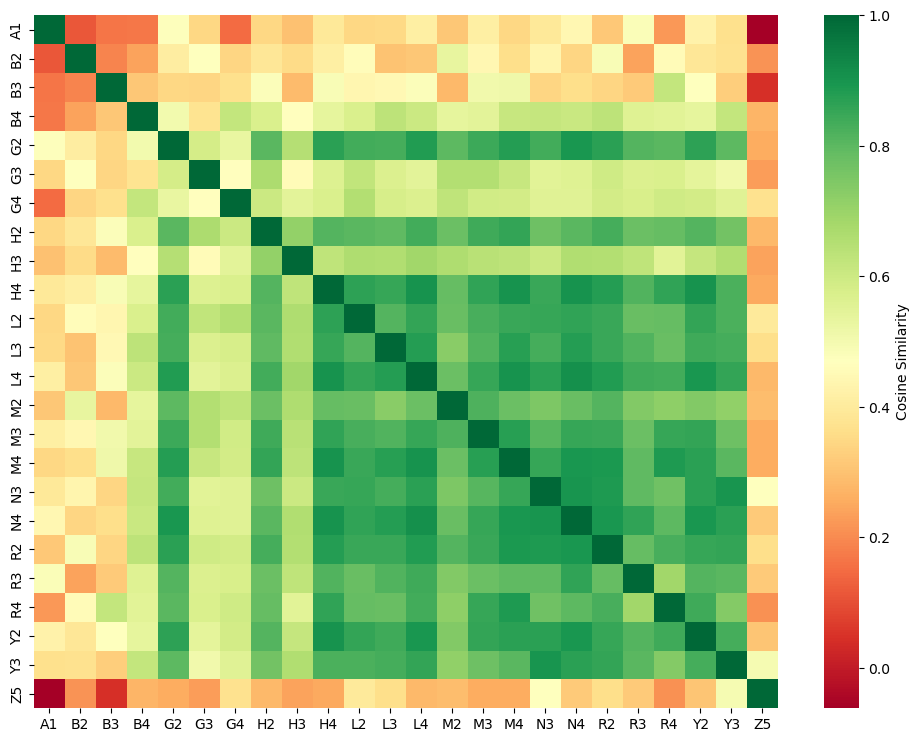

In [19]:
_, ax = plt.subplots(figsize=(12,9))

# Cosine similarity between average embeddings of each color code
avg_embeds_by_color.sort_values(by='color', inplace=True, ignore_index=True)
avg_embeds_by_color.loc[:, 'cossim_mat'] = \
    cosine_similarity(avg_embeds_by_color.avg_embedding.values.tolist()).tolist()

# Visualize Heat Map
sns.heatmap(avg_embeds_by_color.cossim_mat.to_list(), 
            xticklabels=avg_embeds_by_color.color, 
            yticklabels=avg_embeds_by_color.color, 
            cmap='RdYlGn',
            ax=ax, cbar_kws={'label': 'Cosine Similarity'});

These sets of colors roughly correspond to usage percentages -- the foundational set seems to be the "everyday-use" set of colors, where as the extension set is used less frequently for additional distinctions, and the refinement set is used very rarely to denote highly specialized concepts.

In [20]:
total = khipu_df.loc[khipu_df.color != '[UNK]'] \
                      .color.str.extractall('([A-Z]{1}[0-9]{1})') \
                      .count()[0]
color_sets = {'foundational': {'A1', 'B2', 'B3', 'Z5'},
              'extension': {'B4', 'G3', 'G4', 'H3', 'M2'},
              'refinement': {'Y2', 'Y3', 'R2', 'R3', 'R4',
                             'G2', 'H2', 'H4', 'L2', 'L3',
                             'L4', 'N3', 'N4', 'M3', 'M4'}
              }
for k, s in color_sets.items():
    color_set_total = khipu_df.loc[khipu_df.color != '[UNK]'] \
                              .color.str.extractall('([A-Z]{1}[0-9]{1})') \
                              .isin(s) \
                              .sum()[0]
    print(f"% total cords using colors in '{k}' set: ",
          round(color_set_total / total, 4) * 100, 
          '%'          
    )

% total cords using colors in 'foundational' set:  80.95 %
% total cords using colors in 'extension' set:  15.39 %
% total cords using colors in 'refinement' set:  3.66 %


## Within-color Sense-making

While we can partially assess the likelihood that a color had multiple senses by counting the number of clusters associated with each color (and by this measure, the most commonly used colors all seem to have multiple senses), we still have not fully assessed the degree of relatedness between these senses. In this section, I ask the question: how similar is a color to itself in all the contexts in which it appears? Answering this question might help us better understand the degree of polysemy (which should involve highly related senses of a color) or homonymy (which should involve highly distinct senses of a color) in these signs.

Specifically, I will plot cosine similarity histograms for each color code and compare their distributions. To better indicate each color code in the histograms, let's select RGB values that correspond to each to include in the histogram:

In [21]:
# Select KCCS color codes and RGB values (for first Ascher color code aggregated in each KCCS code)
query = '''
        SELECT *
        FROM ascher_color_dc
        '''
kccs = pd.read_sql_query(query, conn)
kccs.loc[:, 'code'] = kccs.COLOR + kccs.INTENSITY.astype('str')
# force H3 and G4 to take on particular shades of blue and green -- otherwise difficult to
# see differences between greens, grays, and blues in plots
kccs.drop(kccs[((kccs.loc[:, 'code'] == 'H3') & (kccs.loc[:, 'AS_COLOR_CD'] != 'PB'))
              | ((kccs.loc[:, 'code'] == 'G4') & (kccs.loc[:, 'AS_COLOR_CD'] != 'DG'))].index,
          inplace=True)
code_rgb = kccs.loc[:, ['code', 'R_DEC', 'G_DEC', 'B_DEC']].drop_duplicates('code')

# Map KCCS code strings to RGB tuples
kccs_to_rgb = {}
for k in embeddings.keys():
    if k not in {'/', ':', '-'}:
        rgb_vals = code_rgb.loc[code_rgb.code == k, ['R_DEC', 'G_DEC', 'B_DEC']]
        kccs_to_rgb[k] = (rgb_vals.R_DEC.values[0], rgb_vals.G_DEC.values[0], rgb_vals.B_DEC.values[0])

Only a couple of colors seem to have patterns consistent with some level of monosemy (i.e. all uses of a color have high internal consistency -- a cosine similarity of 0.5 or above):

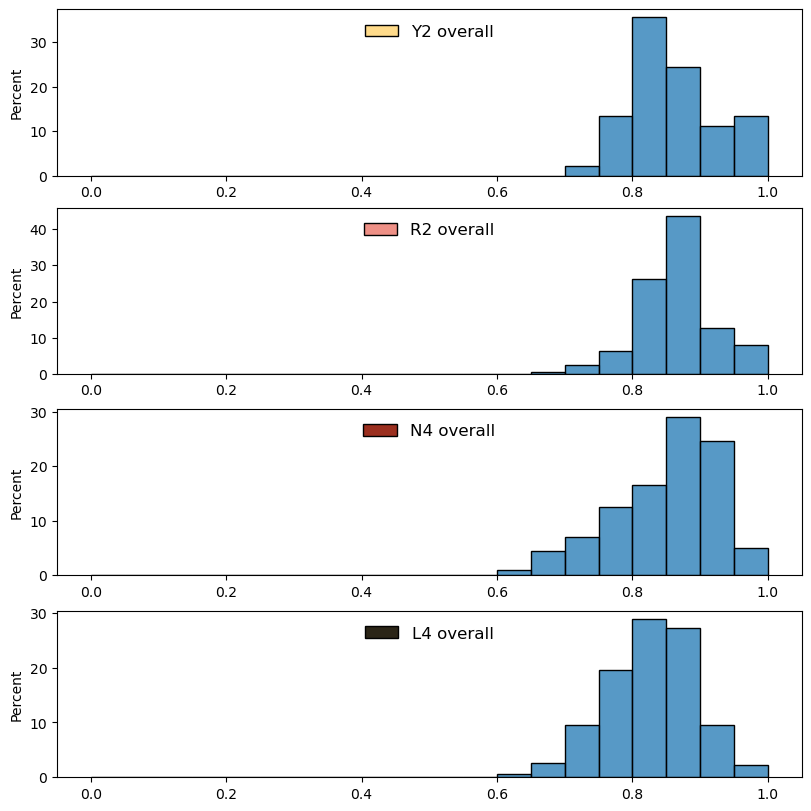

In [22]:
fig, axes = plt.subplots(4, figsize=(8,8), layout='constrained', sharex=True)
monosemes = ['Y2', 'R2', 'N4', 'L4']
for i, ax in enumerate(axes.flatten()):
    try:
        k = monosemes[i]
        sns.histplot(cos_sims[k]['overall'], bins=20, binrange=(0, 1),
                        stat='percent', ax=ax)
        ax.legend(handles=[mpl.patches.Patch(facecolor=kccs_to_rgb[k],
                                                edgecolor="k",
                                                label=f'{k} overall')], 
                    loc='upper center',
                    frameon=False, 
                    fontsize=12)
        ax.tick_params(labelbottom=True);
    except Exception as e:
        print(k, repr(e))

Several do have bimodal peaks -- indicating more divergent use-cases of the same color. Note, though, that the "divergent" cosine similarities are still relatively high -- still at levels consistent with polysemy in NLP studies of contemporary written languages:

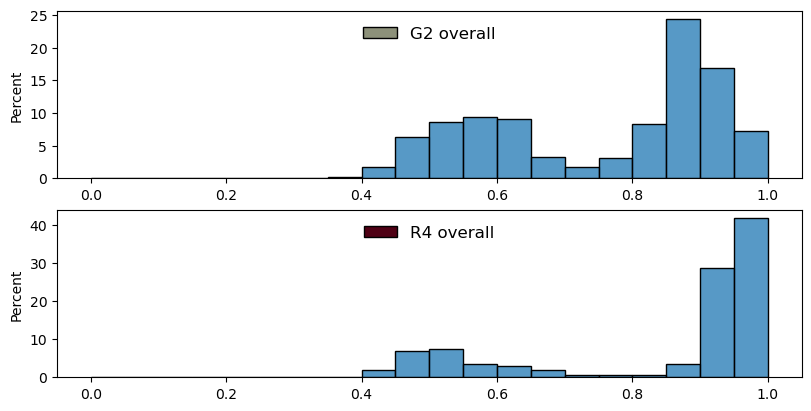

In [23]:
fig, axes = plt.subplots(2, figsize=(8,4), layout='constrained', sharex=True)
bimodal_polysemes = ['G2', 'R4']
for i, ax in enumerate(axes.flatten()):
    try:
        k = bimodal_polysemes[i]
        sns.histplot(cos_sims[k]['overall'], bins=20, binrange=(0, 1),
                        stat='percent', ax=ax)
        ax.legend(handles=[mpl.patches.Patch(facecolor=kccs_to_rgb[k],
                                                edgecolor="k",
                                                label=f'{k} overall')], 
                    loc='upper center',
                    frameon=False, 
                    fontsize=12)
        ax.tick_params(labelbottom=True);
    except Exception as e:
        print(k, repr(e))

More common are histograms that have a peak less than 0.9 and have long tails. These seem to indicate that slightly different senses of the same color are common, but there are a minority of cases that are highly divergent from the norm (although still broadly consistent with polysemic signs).

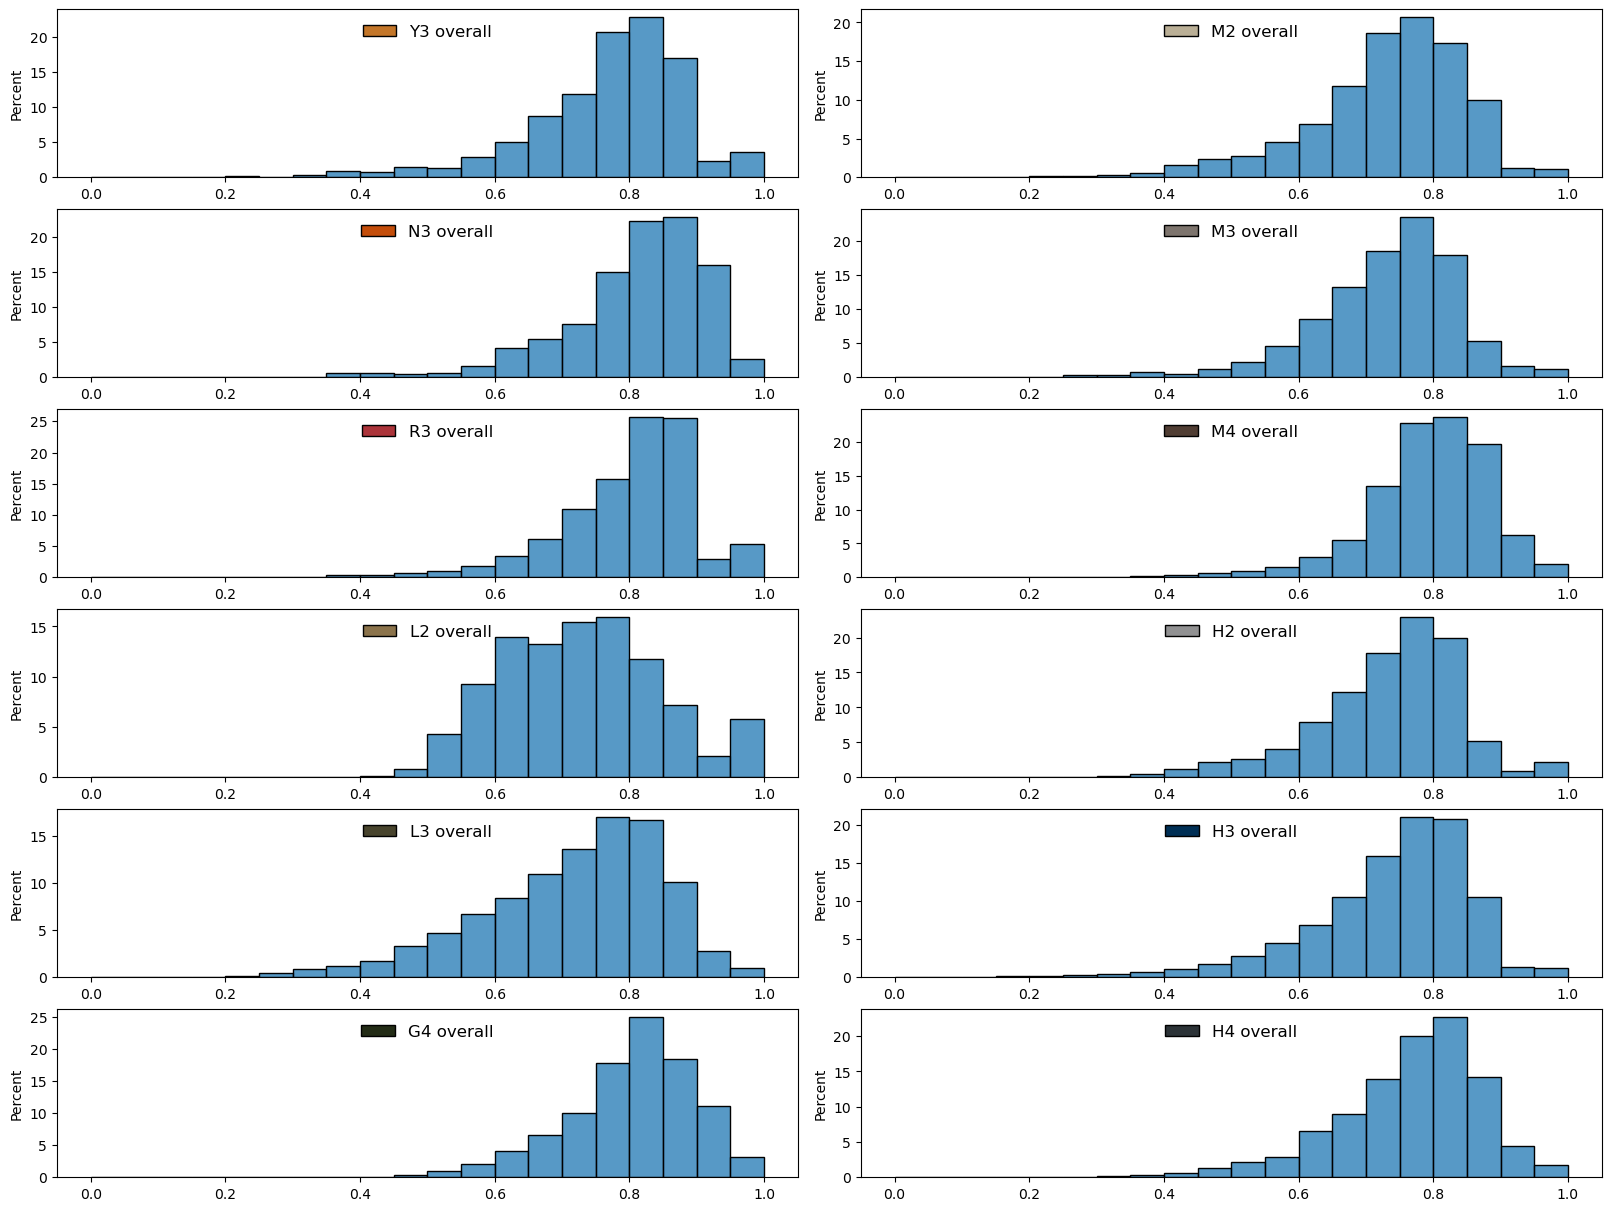

In [24]:
fig, axes = plt.subplots(6, 2, figsize=(16,12), layout='constrained', sharex=True)
long_tail_polysemes_peak_non1 = ['Y3', 'M2', 'N3', 'M3', 'R3', 'M4', 'L2', 'H2', 'L3', 'H3', 'G4', 'H4']

for i, ax in enumerate(axes.flatten()):
    try:
        k = long_tail_polysemes_peak_non1[i]
        sns.histplot(cos_sims[k]['overall'], bins=20, binrange=(0, 1),
                        stat='percent', ax=ax)
        ax.legend(handles=[mpl.patches.Patch(facecolor=kccs_to_rgb[k],
                                                edgecolor="k",
                                                label=f'{k} overall')], 
                    loc='upper center',
                    frameon=False, 
                    fontsize=12)
        ax.tick_params(labelbottom=True);
    except Exception as e:
        print(k, repr(e))

Our entire foundational set is in a set of histograms that has a peak greater than 0.9 and have long tails. These seem to indicate a dominant use for these colors, but also many highly related senses of the same color (reflected in the many clusters of the foundational set of colors):

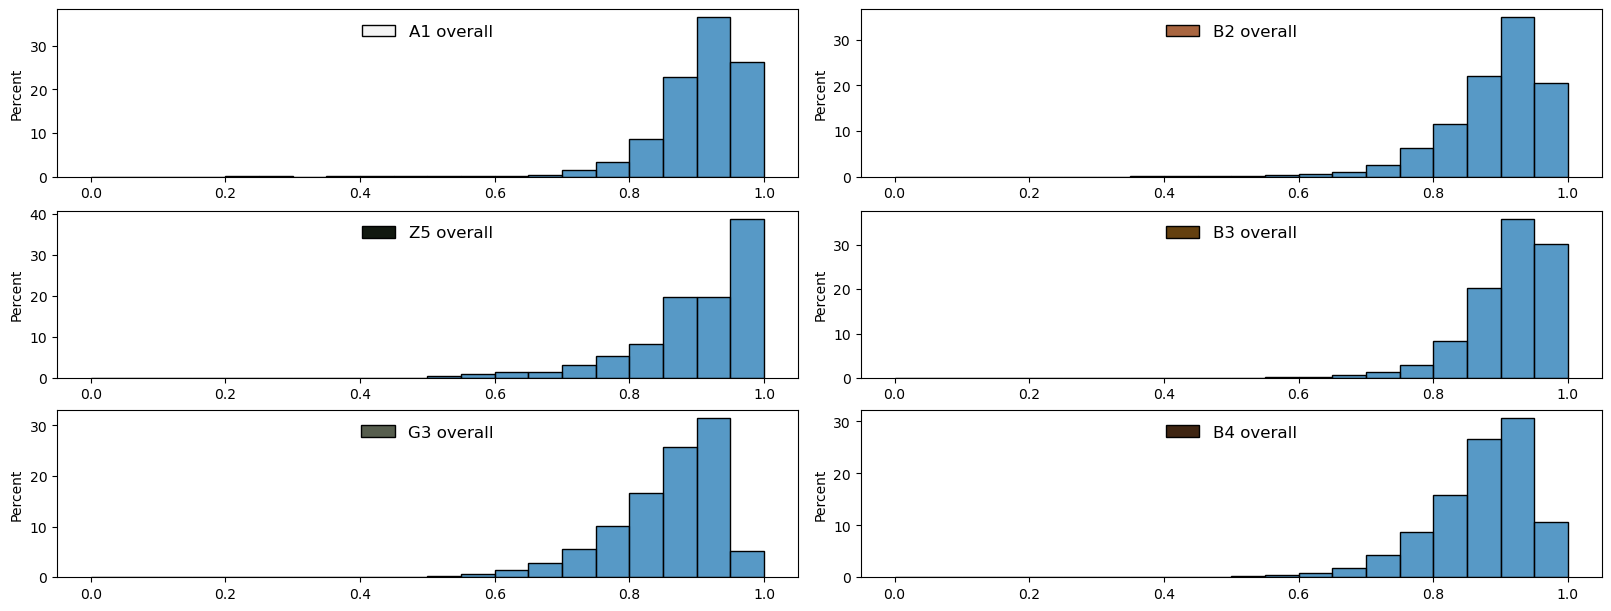

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(16,6), layout='constrained', sharex=True)
long_tail_polysemes_peak_1 = ['A1', 'B2', 'Z5', 'B3', 'G3', 'B4']
for i, ax in enumerate(axes.flatten()):
    try:
        k = long_tail_polysemes_peak_1[i]
        sns.histplot(cos_sims[k]['overall'], bins=20, binrange=(0, 1),
                        stat='percent', ax=ax)
        ax.legend(handles=[mpl.patches.Patch(facecolor=kccs_to_rgb[k],
                                                edgecolor="k",
                                                label=f'{k} overall')], 
                    loc='upper center',
                    frameon=False, 
                    fontsize=12)
        ax.tick_params(labelbottom=True);
    except Exception as e:
        print(k, repr(e))

It has been argued that 'B2' had different senses in KH0503 and KH0491 (possibly playing different arithmetic roles in the two khipus, as per Clindaniel 2019). To get a better feel for what these cosine similarity distributions might mean, we can evaluate these two khipus to see the difference in using 'B2' in the two different contexts. How different are these (arguably different) senses of the same color? Where do they fall in the 'B2' histogram?


Note that this cosine similarity (0.89) is around the peak of the distribution -- suggesting these related (but distinct) senses of 'B2' were common across the OKR.

In [26]:
df = embeddings['B2'].to_pandas()
df = pd.merge(left=df, right=df_geo, on='okr_num')

within = df[df['okr_num'].isin(['KH0503', 'KH0491'])].groupby('okr_num').embeddings \
                .apply(lambda x: np.concatenate(list(x))) \
                .apply(lambda x: cosine_similarity(np.vstack(x))) \
                .apply(unique_cos_sims)

# no radically divergent senses of B2 across the khipus
print(within.apply(lambda l: [i for i in l if i < 0.5]))

between = df[df['okr_num'].isin(['KH0503', 'KH0491'])].groupby('okr_num').embeddings \
                .apply(lambda x: np.concatenate(list(x))) \
                .apply(lambda x: np.mean(x))

# related, but distinct senses
1 - cosine(between['KH0491'], between['KH0503'])

okr_num
KH0491    []
KH0503    []
Name: embeddings, dtype: object


0.8938679202279832

Are divergences a matter of regional or idiosyncratic variation? If so, the observed clusters and histograms may not be evidence of conventionalized semantic domains and polysemy as much as they denote idiosyncracy.

Note that there appear to be very few divergences overall:

In [27]:
mean_pct_divergences = {k:{} for k in color_token_ids.keys()}
for i, k in enumerate(color_token_ids.keys()):
    try:
        # locate divergent cord groups left of .5 cos sim threshold
        df = locate_divergent_cgs(embeddings[k], threshold=0.5)

        # mean pct of divergences (at a khipu-level) from other uses of same color in other cord groups
        mean_pct_divergences[k]['pd_series'] = {'khipu': df.fillna(0) \
                                                           .groupby('okr_num') \
                                                           .divergence_pct \
                                                           .mean(),
                                                'provenance': pd.merge(left=df, right=df_geo, on='okr_num') \
                                                                .fillna(0) \
                                                                .groupby('provenance') \
                                                                .divergence_pct \
                                                                .mean()
        }
        
        mean_pct_divergences[k]['total_count'] = {
            'khipu': mean_pct_divergences[k]['pd_series']['khipu'].count(), 
            'provenance': mean_pct_divergences[k]['pd_series']['provenance'].count()
        }

        mean_pct_divergences[k]['divergences'] = {
            'khipu': mean_pct_divergences[k]['pd_series']['khipu'][
                mean_pct_divergences[k]['pd_series']['khipu'] >= 0.25],
            'provenance': mean_pct_divergences[k]['pd_series']['provenance'][
                mean_pct_divergences[k]['pd_series']['provenance'] >= 0.25]
        }

        mean_pct_divergences[k]['divergent_count'] = {
            'khipu': mean_pct_divergences[k]['divergences']['khipu'].count(),
            'provenance': mean_pct_divergences[k]['divergences']['provenance'].count()
        }

        if mean_pct_divergences[k]['divergent_count']['khipu'] > 0:
            print(f"The following khipu(s) used {k} in a highly divergent way:\n{mean_pct_divergences[k]['divergences']['khipu']}\n\nOverall, {mean_pct_divergences[k]['divergent_count']['khipu']} khipu(s) used {k} in a highly divergent way out of {mean_pct_divergences[k]['total_count']['khipu']} khipus that used the color\n"
            )

        if mean_pct_divergences[k]['divergent_count']['provenance'] > 0:
            print(f"The following provenance(s) used {k} in a highly divergent way:\n\{mean_pct_divergences[k]['divergences']['provenance']}\n\n\Overall, {mean_pct_divergences[k]['divergent_count']['provenance']} provenance(s) used {k} in a highly divergent way out of {mean_pct_divergences[k]['total_count']['provenance']} provenances that used the color\n"
            )
    except Exception as e:
        print(k, repr(e))

The following khipu(s) used N3 in a highly divergent way:
okr_num
KH0581    0.285714
Name: divergence_pct, dtype: float64

Overall, 1 khipu(s) used N3 in a highly divergent way out of 11 khipus that used the color

The following khipu(s) used M2 in a highly divergent way:
okr_num
KH0048    0.302752
KH0344    0.284404
KH0612    0.275229
Name: divergence_pct, dtype: float64

Overall, 3 khipu(s) used M2 in a highly divergent way out of 33 khipus that used the color

The following khipu(s) used Y3 in a highly divergent way:
okr_num
KH0348    0.568627
Name: divergence_pct, dtype: float64

Overall, 1 khipu(s) used Y3 in a highly divergent way out of 7 khipus that used the color

The following khipu(s) used A1 in a highly divergent way:
okr_num
KH0282    0.859976
KH0289    0.933011
KH0346    0.395163
KH0348    0.754534
Name: divergence_pct, dtype: float64

Overall, 4 khipu(s) used A1 in a highly divergent way out of 493 khipus that used the color

The following khipu(s) used B2 in a highly di

Are the divergent cord colors centered in different color clusters or subclusters than other cords of the same color?

In [28]:
divergent_provs = [(k, i) for k in mean_pct_divergences.keys() for i in mean_pct_divergences[k]['divergences']['provenance'].index]
for k, v in divergent_provs:
    print(k, v)
    df_color = pd.merge(left=embeddings[k].to_pandas(), right=df_geo, on='okr_num')
    divergent_embedding = df_color.loc[df_color['provenance'].isin([v]), 'embeddings'].apply(lambda x: np.vstack(x)).mean(axis=0).reshape(1, 3072)
    print("Predicted Cluster", hdbscan.approximate_predict(cluster, umap_100comp_model.transform(divergent_embedding)))
    print("Predicted Sub-cluster", hdbscan.approximate_predict(small_cluster, umap_100comp_model.transform(divergent_embedding)))

# H3 (Callengo) is in expected cluster (3) + subcluster (39)
# R3 (Leymbebamba) is in expected cluster (13), but different subcluster from all others (only R3 cord that is in cluster 232 -- normally the domain of H2)

H3 Callengo
Predicted Cluster (array([3]), array([0.84403406]))
Predicted Sub-cluster (array([39]), array([1.]))
R3 Leymebamba
Predicted Cluster (array([13]), array([1.]))
Predicted Sub-cluster (array([232]), array([0.35697642]))


In [29]:
divergent_okr_nums = [(k, i) for k in mean_pct_divergences.keys() for i in mean_pct_divergences[k]['divergences']['khipu'].index]
for k, v in divergent_okr_nums:
    # focus on most divergent colors
    if k in {'Y3', 'B4', 'R4'}:
        print(k, v)
        df_color = embeddings[k].to_pandas()
        divergent_embedding = np.vstack(df_color.loc[df_color['okr_num'].isin([v]), 'embeddings'].apply(lambda x: np.vstack(x))).mean(axis=0).reshape(1, 3072)
        print("Predicted Cluster", hdbscan.approximate_predict(cluster, umap_100comp_model.transform(divergent_embedding)))
        print("Predicted Sub-cluster", hdbscan.approximate_predict(small_cluster, umap_100comp_model.transform(divergent_embedding)))

# note Y3 (4 cords), B4 (5 cords) are the only cords that fall in cluster 4 and overlap with Z5 
# (perhaps the material type of these khipus adds additional nuance? Y3 is on a camelid khipu, B4 on a human hair khipu)
# R4 (KH0431) is in expected cluster (13), but doesn't fall in a subcluster
# (divergent meaning from others of this color, but still in same specialized semantic domain)

Y3 KH0348
Predicted Cluster (array([4]), array([0.95350791]))
Predicted Sub-cluster (array([43]), array([0.35008259]))
B4 KH0289
Predicted Cluster (array([4]), array([0.57609722]))
Predicted Sub-cluster (array([43]), array([0.16291822]))
R4 KH0431
Predicted Cluster (array([13]), array([1.]))
Predicted Sub-cluster (array([-1]), array([0.]))


Note that all cord colors were used in at least two khipus and provenances -- i.e. none are specific to one khipu or archive:

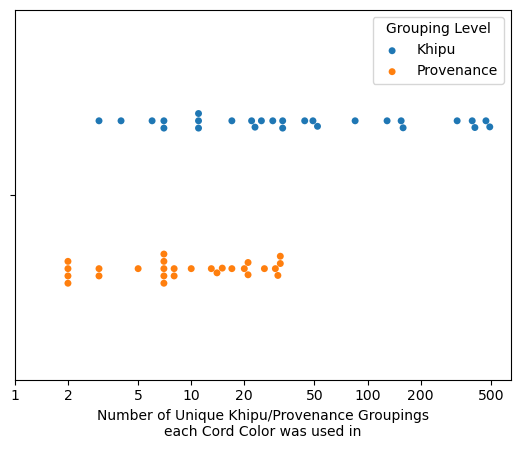

In [30]:
df = pd.concat([pd.DataFrame({'level': 'khipu', 
                         'count': np.log10([mean_pct_divergences[k]['total_count']['khipu'] for k in mean_pct_divergences.keys()])
                         }
                ),
                pd.DataFrame({'level': 'provenance', 
                         'count': np.log10([mean_pct_divergences[k]['total_count']['provenance'] for k in mean_pct_divergences.keys()])
                         }
                )
          ]
         )
sns.swarmplot(data=df, x='count', hue='level', dodge=True, orient='h')
plt.legend(title='Grouping Level', labels=['Khipu', 'Provenance'])
plt.xticks(np.log10([1, 2, 5, 10, 20, 50, 100, 200, 500]), [1, 2, 5, 10, 20, 50, 100, 200, 500])
plt.xlabel('Number of Unique Khipu/Provenance Groupings\neach Cord Color was used in');

Also, khipus/provenances that are divergent account for only a small percentage of overall use of a color. Larger divergence percentages appear to partially be a result of small sample size -- R4 is divergent in 1/4 khipus, Y3 in 1/7 khipus, R3 divergent in 1/7 provenances (Leymebamba), H3 in 1/17 provenances (Callengo).

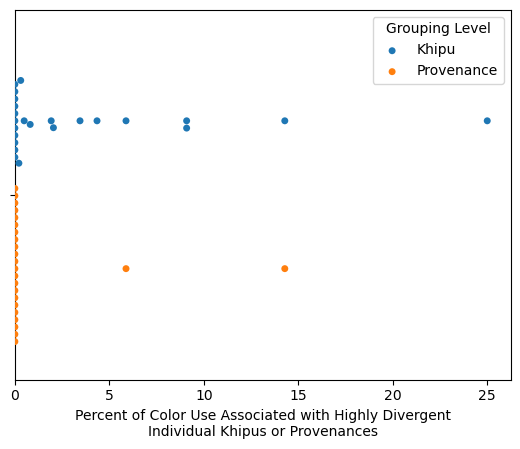

In [31]:
df = pd.concat([pd.DataFrame({'level': 'khipu', 
                         'pct_div': [100 * mean_pct_divergences[k]['divergent_count']['khipu'] / mean_pct_divergences[k]['total_count']['khipu']
 for k in mean_pct_divergences.keys() if k not in [':','-','/']]
                         }
                       ),
            pd.DataFrame({'level': 'provenance', 
                         'pct_div': [100 * mean_pct_divergences[k]['divergent_count']['provenance'] / mean_pct_divergences[k]['total_count']['provenance']
 for k in mean_pct_divergences.keys() if k not in [':','-','/']]
                         }
                       )
          ]
         )

sns.swarmplot(df, x='pct_div', hue='level', dodge=True, orient='h')
plt.xlim(0)
plt.legend(title='Grouping Level', labels=['Khipu', 'Provenance'])
plt.xlabel('Percent of Color Use Associated with Highly Divergent\nIndividual Khipus or Provenances');

## Clustering Cord Group and Khipu Level Color Patterns

Are there consistent ways in which colors are patterned at the cord group level (i.e. khipu "phrases") and khipu level (i.e. khipu "topics")? If so, is there evidence of archive/provenance-specific color patterning or are they combined in similar ways across archives?

To assess these questions, we first must compute aggregate (average) embeddings across cord groups and then employ the same dimension reduction and clustering approach used at a cord level. Note that the minimum cluster size for HDBSCAN is reduced down to either 15 (for cord groups) or 5 (for full khipus) to account for the inherent sample size reduction as a result of aggregation.

In [32]:
if USE_PRECOMPUTED:
    # load precomputed embeddings and cluster labels
    cg_embeddings_dataset = load_from_disk(f'{file_path}/cg_embeddings')
    kh_embeddings_pd = pd.DataFrame(cg_embeddings_dataset.to_pandas() \
                                                              .groupby('okr_num') \
                                                              .cg_embeddings \
                                                              .mean()) \
                            .rename(columns={'cg_embeddings': 'embeddings'})
    kh_embeddings_dataset = Dataset.from_pandas(kh_embeddings_pd)
    result_agg_dfs = {k: pd.read_pickle(cluster_model_path + k + '_clustering_result.pkl')
                      for k in ['phrases', 'topics']}
else:
    # compute aggregated cord group ("phrase") and khipu ("topic") embeddings
    cg_embeddings_dataset = map_cg_embedding_computation(encoded, model, file_path)

    # reduce dimensionality and cluster
    result_agg_dfs = {}
    for i in ['phrases', 'topics']:
        if i == 'phrases':
            # compute cord group
            e = cg_embeddings_dataset['cg_embeddings']
            min_cluster_size = 15
        else:
            kh_embeddings_pd = pd.DataFrame(cg_embeddings_dataset.to_pandas() \
                                                              .groupby('okr_num') \
                                                              .cg_embeddings \
                                                              .mean()) \
                            .rename(columns={'cg_embeddings': 'embeddings'})
            kh_embeddings_dataset = Dataset.from_pandas(kh_embeddings_pd)
            e = kh_embeddings_dataset['embeddings']
            min_cluster_size = 5

        # Dimension Reduction so HDBSCAN can better identify clusters
        umap_agg_100comp_model = umap.UMAP(n_neighbors=15,
                                    n_components=100,
                                    min_dist=0.0,
                                    metric='cosine',
                                    random_state=SEED) \
                        .fit_transform(e)

        # Identify clusters with HDBSCAN
        agg_cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                      metric='euclidean',
                                      cluster_selection_method='eom') \
                        .fit(umap_agg_100comp_model)

        # Prepare data for plotting in two dimensions now that clusters have been identified
        umap_agg_2comp_model = umap.UMAP(n_neighbors=15,
                            n_components=2,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=SEED) \
                        .fit_transform(e)
        result_agg = pd.DataFrame(umap_agg_2comp_model, columns=['x', 'y'])
        result_agg['labels'] = agg_cluster.labels_
        
        result_agg_dfs[i] = result_agg
        result_agg.to_pickle(cluster_model_path + i + '_clustering_result.pkl')

### Cord Group "Phrase" Clusters

HDBSCAN has identified 127 unique "phrase" clusters and these clusters account for a large number of the cord groups overall (over 87%).

% Assigned a Cluster: 87.22694174757281


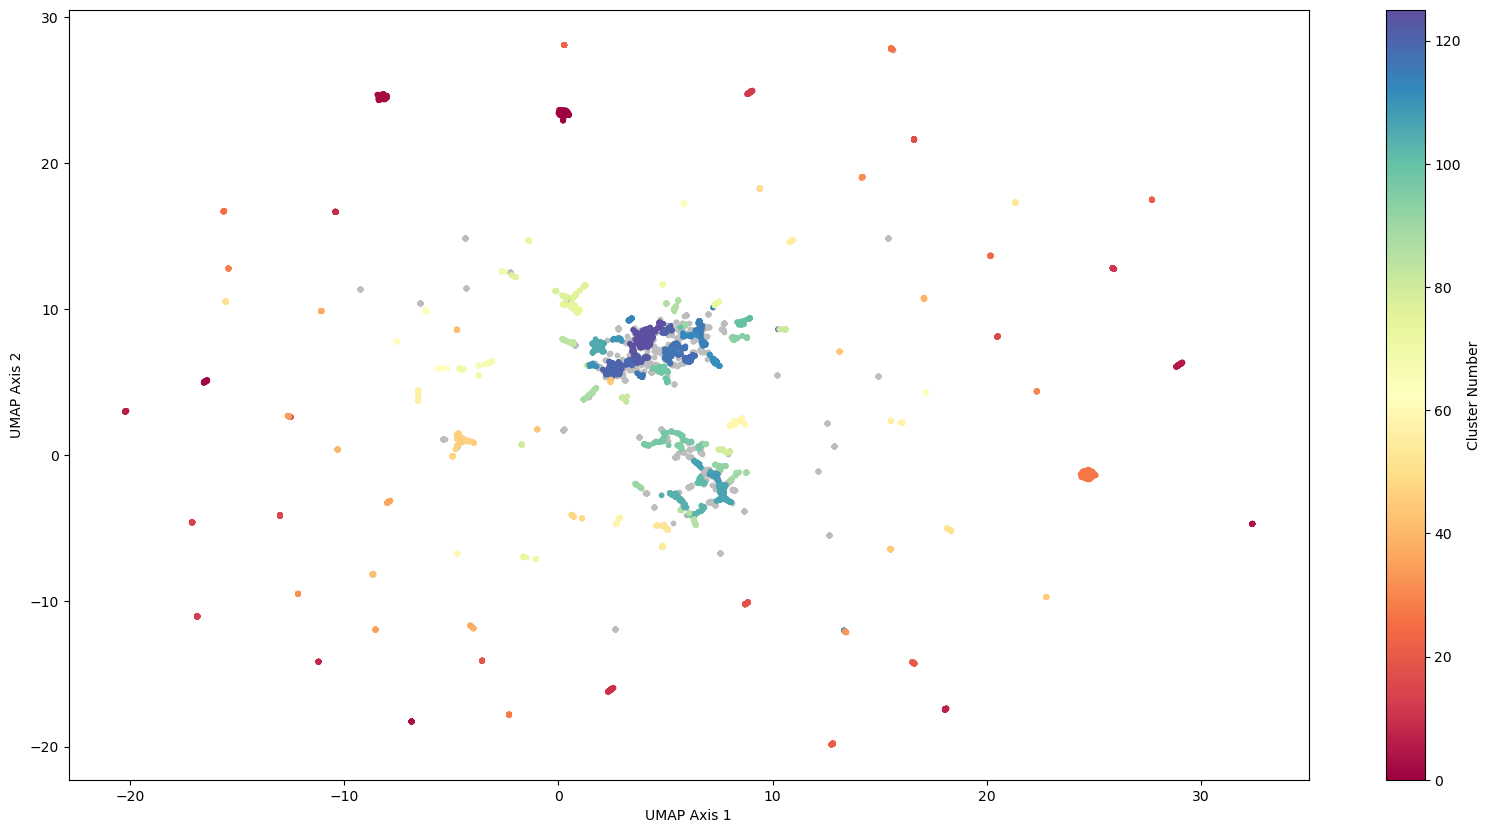

In [33]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers_cg = result_agg_dfs['phrases'].loc[result_agg_dfs['phrases'].labels == -1, :]
clustered_cg = result_agg_dfs['phrases'].loc[result_agg_dfs['phrases'].labels != -1, :]

print(f'% Assigned a Cluster: {100 * len(clustered_cg) / (len(outliers_cg) + len(clustered_cg))}')

plt.scatter(outliers_cg.x, outliers_cg.y, color='#BDBDBD', s=10) # outliers in gray
plt.scatter(clustered_cg.x, clustered_cg.y, c=clustered_cg.labels, s=10, cmap='Spectral')
plt.colorbar(label='Cluster Number')
plt.xlabel('UMAP Axis 1')
plt.ylabel('UMAP Axis 2');

### Khipu "Topic" Clusters

HDBSCAN has identified 20 unique "topic" clusters and these clusters account for a large number of the khipus overall (slightly over 88%).

% Assigned a Cluster: 88.01996672212978


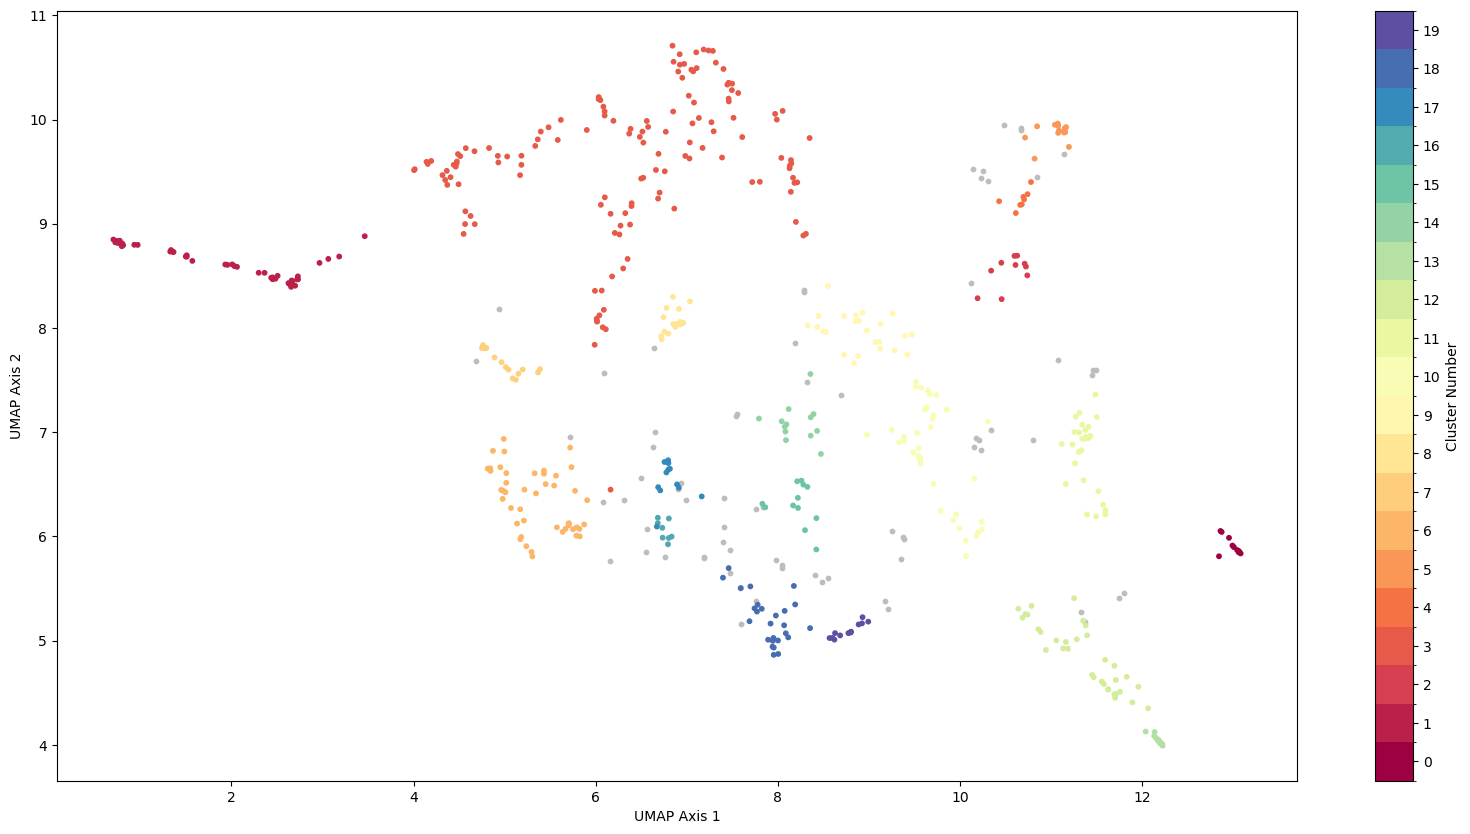

In [34]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers_t = result_agg_dfs['topics'].loc[result_agg_dfs['topics'].labels == -1, :]
clustered_t = result_agg_dfs['topics'].loc[result_agg_dfs['topics'].labels != -1, :]

print(f'% Assigned a Cluster: {100 * len(clustered_t) / (len(outliers_t) + len(clustered_t))}')

cmap = mpl.cm.Spectral
bounds = np.arange(result_agg_dfs['topics'].labels.nunique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(outliers_t.x, outliers_t.y, color='#BDBDBD', s=10)
plt.scatter(clustered_t.x, clustered_t.y, c=clustered_t.labels, s=10, cmap=cmap)
plt.xlabel('UMAP Axis 1')
plt.ylabel('UMAP Axis 2')

cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             ax=ax, orientation='vertical', label='Cluster Number')
cb.set_ticks(bounds[:-1] + 0.5)
cb.set_ticklabels(bounds[:-1]);

Are khipus with different color patterns correctly assigned to different clusters? Let's take a look at KH0491 and KH0503 again from Inkawasi (which have are "dark" and "light" shades, respectively). Note that the two khipus do in fact fall in separate clusters (in the plot, topic 12 is in the lower right, topic 6 is in the lower left)

In [36]:
# treat each cord group or khipu as its own "document"
cg_docs_df = cg_embeddings_dataset.to_pandas() \
                                  .rename({'color': 'doc'}, axis='columns')
cg_docs_df['label'] = result_agg_dfs['phrases'].labels
kh_docs_df = kh_embeddings_dataset.to_pandas() \
                                  .rename({'embeddings': 'doc'}, axis='columns')
kh_docs_df['label'] = result_agg_dfs['topics'].labels

for k in ['KH0491', 'KH0503']:
    topic = kh_docs_df[kh_docs_df.okr_num == k].label.values[0]
    print(f"{k} is in topic {topic}, centered at {tuple(clustered_t.loc[clustered_t.labels == topic, ['x', 'y']].mean())}")

KH0491 is in topic 12, centered at (11.365002632141113, 4.847522735595703)
KH0503 is in topic 6, centered at (5.355777740478516, 6.343739986419678)


It also looks like color patterns were broadly used across different provenances/archives at both the cord group ("phrase") and khipu ("topic") levels:

In [37]:
for k, df in {'phrases': cg_docs_df, 'topics': kh_docs_df}.items():
    # compute % from more than one provenance, as well as 4 or more (note generally used in many archives)
    cluster_sizes = extract_cluster_sizes(df)
    cluster_by_prov = extract_cluster_sizes(df, by='provenance')

    print(f'% {k} from more than one provenance')
    print(100 * sum(cluster_by_prov[cluster_by_prov.label != -1].groupby('label').provenance.count() > 1)
          / (len(cluster_sizes) - 1))

    print(f'% {k} from 4 or provenances')
    print(100 * cluster_sizes[cluster_sizes.join((cluster_by_prov.groupby('label') \
                                                           .provenance.count() >= 4),
                                           on='label').provenance
                        & (cluster_sizes.label != -1)].loc[:, 'size'].sum()
        / (cluster_sizes[cluster_sizes.label != -1].loc[:, 'size'].sum()))
    print('\n')

% phrases from more than one provenance
95.23809523809524
% phrases from 4 or provenances
84.81739130434782


% topics from more than one provenance
100.0
% topics from 4 or provenances
95.08506616257088


